In [170]:
import crocoddyl
import mujoco
import mujoco.viewer
import mim_solvers
import numpy as np
import matplotlib.pyplot as plt
import hppfcl
import time
from os.path import dirname, join, abspath
np.set_printoptions(precision=4, linewidth=180)

import pin_utils, mpc_utils
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer

from mim_robots.pybullet.env import BulletEnvWithGround
from mim_robots.robot_loader import load_bullet_wrapper, load_mujoco_model, get_robot_list, load_pinocchio_wrapper
from mim_robots.robot_list import MiM_Robots
from numpy.linalg import norm, solve
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize
from scipy.optimize import Bounds


In [2]:
# Robot simulator Mujoco
RobotInfo = MiM_Robots["iiwa"]
mj_model = load_mujoco_model("iiwa")
mj_data = mujoco.MjData(mj_model)
robot_simulator = load_pinocchio_wrapper("iiwa")
pin_model = robot_simulator.model
pin_collision_model = robot_simulator.collision_model
pin_visual_model = robot_simulator.visual_model
pin_data = pin_model.createData()
viz = MeshcatVisualizer(pin_model, pin_collision_model, pin_visual_model)

In [3]:
def create_obs(pos, rot, m, d, num_obs):
    obsPose = pin.SE3.Identity()
    obsPose.rotation = rot
    obsPose.translation = pos
    obsObj = pin.GeometryObject("obstacle"+str(num_obs),
                                m.getFrameId("universe"),
                                m.frames[pin_model.getFrameId("universe")].parent,
                                hppfcl.Box(d[0], d[1], d[2]),
                                obsPose)
    return obsObj

def convert_2_cart(states, frame_id):
    size = states.shape
    cart_pred = np.zeros(shape = (size[0], size[1], 3))
    dummy_robot = load_pinocchio_wrapper("iiwa")
    m = dummy_robot.model
    d = dummy_robot.data
    for cycle in range(size[0]):
        for t in range(size[1]):
            q = states[cycle,t,:m.nq]
            v = states[cycle,t,m.nq:]
            pin.forwardKinematics(m,d,q)
            pin.framesForwardKinematics(m, d, q)
            pin.updateFramePlacements(m, d)  
            p = d.oMf[frame_id].copy()
            cart_pred[cycle,t,:] = p.translation

    return cart_pred

In [4]:
# Robot simulator Mujoco
RobotInfo = MiM_Robots["iiwa"]
mj_model = load_mujoco_model("iiwa")
mj_data = mujoco.MjData(mj_model)
robot_simulator = load_pinocchio_wrapper("iiwa")
pin_model = robot_simulator.model
pin_collision_model = robot_simulator.collision_model
pin_visual_model = robot_simulator.visual_model
pin_data = pin_model.createData()
link_names = ["A1", "A2", "A3", "A4", "A5", "A6", "A7"]

In [5]:
# Extract robot model
nq = robot_simulator.model.nq
nv = robot_simulator.model.nv
nu = nq; nx = nq+nv
q0 = np.array([0.2, 0.7, 0.3, -1.1, -0.3, 0.3, 0.])
# q0 = pin.neutral(pin_model)
v0 = np.zeros(nv)
idx = robot_simulator.index('A7')
pin.forwardKinematics(pin_model, pin_data, q0)
x0 = np.concatenate([q0, v0])
print(pin_data.oMi[idx].translation)

[0.6784 0.262  0.5617]


In [6]:
# Add robot to Mujoco and initialize
mj_renderer = mujoco.Renderer(mj_model)
mujoco.mj_step(mj_model, mj_data)
mj_renderer.update_scene(mj_data)
mj_data.qpos = q0
mj_data.qvel = v0
mujoco.mj_forward(mj_model, mj_data)
mj_dt=1e-3

In [7]:
# # # # # # # # # # # # # # #
###  SETUP CROCODDYL OCP  ###
# # # # # # # # # # # # # # #

# State and actuation model for MPC and IRL
stateMPC = crocoddyl.StateMultibody(pin_model)
stateIRL = crocoddyl.StateMultibody(pin_model)
actuationMPC = crocoddyl.ActuationModelFull(stateMPC)
actuationIRL = crocoddyl.ActuationModelFull(stateIRL)
# Running and terminal cost models for MPC and IRL
runningCostModelMPC = crocoddyl.CostModelSum(stateMPC)
runningCostModelIRL = crocoddyl.CostModelSum(stateIRL)
terminalCostModelMPC = crocoddyl.CostModelSum(stateMPC)
terminalCostModelIRL = crocoddyl.CostModelSum(stateIRL)

# Create cost terms 
# COLLISION COST 
# Create a capsule for the arm
capsul_disp = []
for i,ln in enumerate(link_names[:-1]):
    capsul_disp.append(robot_simulator.placement(q0,robot_simulator.index(ln)+1).translation - robot_simulator.placement(q0,robot_simulator.index(ln)).translation)
capsul_disp = np.stack(capsul_disp)
capsul_lengths = np.linalg.norm(capsul_disp,axis=-1)
capsul_radius = 0.04
capsul_tol = capsul_radius/4
ig_link_names = []
pin_joint_ids = []
geomModel           = pin.GeometryModel() 
for i,ln in enumerate(link_names[:-1]):
    pin_link_id         = pin_model.getFrameId(ln)
    pin_joint_id        = pin_model.getJointId(ln)
    pin_joint_ids.append(pin_joint_id)
    placement = pin.SE3.Identity()
    placement.rotation = robot_simulator.placement(q0,pin_joint_id).rotation.T
    placement.translation += np.array([0, 0, capsul_lengths[i]/2])@placement.rotation.T
    # placement.translation += (capsul_disp[i]/2)@placement.rotation.T
    if ln == 'A6':
        placement.translation += np.array([0.03, 0, 6.0700e-02])
    ig_link_names.append(geomModel.addGeometryObject(pin.GeometryObject("arm_link_"+str(i+1), 
                                                      pin_model.joints[pin_model.getJointId(ln)].id,
                                                      placement,
                                                      hppfcl.Capsule(capsul_radius, capsul_lengths[i]/2 - capsul_tol))))
    # ig_link_names.append(geomModel.addGeometryObject(pin.GeometryObject("arm_link_"+str(i), 
    #                                                   pin_link_id, 
    #                                                   pin_model.frames[pin_model.getFrameId(ln)].parentJoint,
    #                                                   hppfcl.Capsule(0, 0.5),
    #                                                   pin.SE3.Identity())))
    # if i > 0:
    #     geomModel.addCollisionPair(pin.CollisionPair(ig_link_names[i],ig_link_names[i-1]))
# print("num collision pairs - after addition:",len(geomModel.collisionPairs))

In [8]:
# Create obstacles in the world
# from : [0.6784 0.262  0.5617]
# to : [0.4,  -0.5,  0.35]
obs_num = 3
obs_p = []
obs_p.append(np.array([0.75, 0.0, 0.55]))
obs_p.append(np.array([0.65, -0.15, 0.45]))
obs_p.append(np.array([0.5, -0.3, 0.4]))
for i,p in enumerate(obs_p):
    obsObj = create_obs(p, pin.SE3.Identity().rotation, pin_model, [0.1]*3, i)
    ig_obs = geomModel.addGeometryObject(obsObj)
    for j in ig_link_names[-2:]:
        # geomModel.addCollisionPair(pin.CollisionPair(ig_obs, ig_link_names[j])) # Mine
        geomModel.addCollisionPair(pin.CollisionPair(ig_link_names[j],ig_obs)) # Original


print("num collision pairs - after obstacles:",len(geomModel.collisionPairs))

num collision pairs - after obstacles: 6


/tmp/ipykernel_19519/628141677.py:7: UserWarning: Deprecated member. Use Frame.parentJoint instead.
  m.frames[pin_model.getFrameId("universe")].parent,
/tmp/ipykernel_19519/628141677.py:5: UserWarning: This function has been marked as deprecated and will be removed in a future release.
  obsObj = pin.GeometryObject("obstacle"+str(num_obs),


In [9]:
# endeff frame translation goal
endeff_frame_id = pin_model.getFrameId("contact")
endeff_joint_id = pin_model.getJointId("contact")
endeff_translation = pin_data.oMf[endeff_frame_id].translation.copy()
endeff_translation = np.array([0.4,  -0.5,  0.35])

In [10]:
########################
##### Cost for MPC #####
########################
# Data collectors
dataCollectorActMPC = crocoddyl.DataCollectorActMultibody(pin_data, crocoddyl.ActuationDataAbstract(actuationMPC))
dataCollectorStateMPC = crocoddyl.DataCollectorMultibody(pin_data)
dataCollectorTranslationMPC = crocoddyl.DataCollectorMultibody(pin_data)
dataCollectorCollisionMPC = crocoddyl.DataCollectorMultibody(pin_data)
# Control regularization cost
uResidualMPC = crocoddyl.ResidualModelControlGrav(stateMPC)
uRegCostMPC = crocoddyl.CostModelResidual(stateMPC, uResidualMPC)
uCostDataMPC = uRegCostMPC.createData(dataCollectorActMPC)
# State regularization cost
xResidualMPC = crocoddyl.ResidualModelState(stateMPC, x0)
xRegCostMPC = crocoddyl.CostModelResidual(stateMPC, xResidualMPC)
xCostDataMPC = xRegCostMPC.createData(dataCollectorStateMPC)
# endeff frame translation cost
frameTranslationResidualMPC = crocoddyl.ResidualModelFrameTranslation(stateMPC, endeff_frame_id, endeff_translation)
frameTranslationCostMPC = crocoddyl.CostModelResidual(stateMPC, frameTranslationResidualMPC)
translationCostDataMPC = frameTranslationCostMPC.createData(dataCollectorTranslationMPC)

In [11]:
########################
##### Cost for IRL #####
########################
# Data collectors
dataCollectorActIRL = crocoddyl.DataCollectorActMultibody(pin_data, crocoddyl.ActuationDataAbstract(actuationIRL))
dataCollectorStateIRL = crocoddyl.DataCollectorMultibody(pin_data)
dataCollectorTranslationIRL = crocoddyl.DataCollectorMultibody(pin_data)
dataCollectorCollisionIRL = crocoddyl.DataCollectorMultibody(pin_data)
# Control regularization cost
uResidualIRL = crocoddyl.ResidualModelControlGrav(stateIRL)
uRegCostIRL = crocoddyl.CostModelResidual(stateIRL, uResidualIRL)
uCostDataIRL = uRegCostIRL.createData(dataCollectorActIRL)
# State regularization cost
xResidualIRL = crocoddyl.ResidualModelState(stateIRL, x0)
xRegCostIRL = crocoddyl.CostModelResidual(stateIRL, xResidualIRL)
xCostDataIRL = xRegCostIRL.createData(dataCollectorStateIRL)
# endeff frame translation cost
frameTranslationResidualIRL = crocoddyl.ResidualModelFrameTranslation(stateIRL, endeff_frame_id, endeff_translation)
frameTranslationCostIRL = crocoddyl.CostModelResidual(stateIRL, frameTranslationResidualIRL)
translationCostDataIRL = frameTranslationCostIRL.createData(dataCollectorTranslationIRL)

In [12]:
# Weights (Shared in MPC and IRL)
w_running = {}
w_terminal = {}

w_running['stateReg'] = 1e-1
w_running['ctrlRegGrav'] = 1e-4
w_running['translation'] = 1e1
w_terminal['stateReg'] = 1e-1
w_terminal['translation'] = 1e2

runningCostDataMPC = {}
terminalCostDataMPC = {}
runningCostDataIRL = {}
terminalCostDataIRL = {}

# Building Cost Function for MPC
runningCostModelMPC.addCost("stateReg", xRegCostMPC, w_running['stateReg'])
runningCostModelMPC.addCost("ctrlRegGrav", uRegCostMPC, w_running['ctrlRegGrav'])
runningCostModelMPC.addCost("translation", frameTranslationCostMPC, w_running['translation'])
terminalCostModelMPC.addCost("stateReg", xRegCostMPC, w_terminal['stateReg'])
terminalCostModelMPC.addCost("translation", frameTranslationCostMPC, w_terminal['translation'])

runningCostDataMPC['stateReg'] = xCostDataMPC
runningCostDataMPC['ctrlRegGrav'] = uCostDataMPC
runningCostDataMPC['translation'] = translationCostDataMPC
terminalCostDataMPC['stateReg'] = xCostDataMPC
terminalCostDataMPC['translation'] = translationCostDataMPC

# Building Cost Function for IRL
runningCostModelIRL.addCost("stateReg", xRegCostIRL, w_running['stateReg'])
runningCostModelIRL.addCost("ctrlRegGrav", uRegCostIRL, w_running['ctrlRegGrav'])
runningCostModelIRL.addCost("translation", frameTranslationCostIRL, w_running['translation'])
terminalCostModelIRL.addCost("stateReg", xRegCostIRL, w_terminal['stateReg'])
terminalCostModelIRL.addCost("translation", frameTranslationCostIRL, w_terminal['translation'])

runningCostDataIRL['stateReg'] = xCostDataIRL
runningCostDataIRL['ctrlRegGrav'] = uCostDataIRL
runningCostDataIRL['translation'] = translationCostDataIRL
terminalCostDataIRL['stateReg'] = xCostDataIRL
terminalCostDataIRL['translation'] = translationCostDataIRL

In [13]:
collision_radius = 0.2

# Add collision cost to the MPC and IRL 
activationCollisionMPC = crocoddyl.ActivationModel2NormBarrier(3, collision_radius)
activationCollisionIRL = crocoddyl.ActivationModel2NormBarrier(3, collision_radius)

collisionPairCostDataMPC = []
residualCollisionMPC = []
costCollisionMPC = []

collisionPairCostDataIRL = []
residualCollisionIRL = []
costCollisionIRL = []

constraintsMPC = crocoddyl.ConstraintModelManager(stateMPC, nu)
constraintsIRL = crocoddyl.ConstraintModelManager(stateIRL, nu)

MPC_Constrained = False
IRL_Constrained = False

collision_contraintMPC = []
collision_contraintIRL = []

c = 0
for i in range(len(geomModel.collisionPairs)):
    
    # Weights for Collision
    w_running['collision'+str(c)] = 100
    w_terminal['collision'+str(c)] = 1000
    if MPC_Constrained:
        # Add Collision Constraint for MPC
        collision_contraintMPC.append(crocoddyl.ConstraintModelResidual(
        stateMPC,
        crocoddyl.ResidualModelPairCollision(stateMPC, nu, geomModel, i, pin_joint_ids[-1]),
        np.array([1, 1, 1])*-np.inf,
        np.array([1, 1, 1])))
        constraintsMPC.addConstraint("collision_constraint"+str(c), collision_contraintMPC[i])
    else:
        # MPC Collision Cost
        residualCollisionMPC.append(crocoddyl.ResidualModelPairCollision(stateMPC, nu, geomModel, i, pin_joint_ids[-1]))
        costCollisionMPC.append(crocoddyl.CostModelResidual(stateMPC, activationCollisionMPC, residualCollisionMPC[i]))
        collisionPairCostDataMPC.append(costCollisionMPC[i].createData(dataCollectorCollisionMPC))
        runningCostModelMPC.addCost("collision"+str(c), costCollisionMPC[i], w_running['collision'+str(c)])
        terminalCostModelMPC.addCost("collision"+str(c), costCollisionMPC[i], w_terminal['collision'+str(c)])
        runningCostDataMPC['collision'+str(c)] = costCollisionMPC[i].createData(dataCollectorCollisionMPC)
        terminalCostDataMPC['collision'+str(c)] = costCollisionMPC[i].createData(dataCollectorCollisionMPC)

    if IRL_Constrained:
        # Add Collision Constraint for IRL
        collision_contraintIRL.append(crocoddyl.ConstraintModelResidual(
        stateIRL,
        crocoddyl.ResidualModelPairCollision(stateIRL, nu, geomModel, i, pin_joint_ids[-1]),
        np.array([-np.inf, -np.inf, -np.inf]),
        np.array([np.inf, np.inf, np.inf])))
        constraintsIRL.addConstraint("collision_constraint"+str(c), collision_contraintIRL[i])
    else:
        # IRL Collision Cost
        residualCollisionIRL.append(crocoddyl.ResidualModelPairCollision(stateIRL, nu, geomModel, i, pin_joint_ids[-1]))
        costCollisionIRL.append(crocoddyl.CostModelResidual(stateIRL, activationCollisionIRL, residualCollisionIRL[i]))
        collisionPairCostDataIRL.append(costCollisionIRL[i].createData(dataCollectorCollisionIRL))
        runningCostModelIRL.addCost("collision"+str(c), costCollisionIRL[i], w_running['collision'+str(c)])
        terminalCostModelIRL.addCost("collision"+str(c), costCollisionIRL[i], w_terminal['collision'+str(c)])
        runningCostDataIRL['collision'+str(c)] = costCollisionIRL[i].createData(dataCollectorCollisionIRL)
        terminalCostDataIRL['collision'+str(c)] = costCollisionIRL[i].createData(dataCollectorCollisionIRL)
    c=c+1

In [14]:
# Create Differential Action Model (DAM), i.e. continuous dynamics and cost functions
if MPC_Constrained:
    running_DAMMPC = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateMPC, actuationMPC, runningCostModelMPC, constraintsMPC)
    terminal_DAMMPC = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateMPC, actuationMPC, terminalCostModelMPC, constraintsMPC)
else:
    running_DAMMPC = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateMPC, actuationMPC, runningCostModelMPC)
    terminal_DAMMPC = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateMPC, actuationMPC, terminalCostModelMPC)

# Create Differential Action Model (DAM), i.e. continuous dynamics and cost functions
if IRL_Constrained:
    running_DAMIRL = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateIRL, actuationIRL, runningCostModelIRL, constraintsIRL)
    terminal_DAMIRL = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateIRL, actuationIRL, terminalCostModelIRL, constraintsIRL)
else:
    running_DAMIRL = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateIRL, actuationIRL, runningCostModelIRL)
    terminal_DAMIRL = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateIRL, actuationIRL, terminalCostModelIRL)

In [15]:
dt = 1e-2

# Create Integrated Action Model (IAM), i.e. Euler integration of continuous dynamics and cost
runningModelMPC = crocoddyl.IntegratedActionModelEuler(running_DAMMPC, dt)
terminalModelMPC = crocoddyl.IntegratedActionModelEuler(terminal_DAMMPC, 0.)
runningModelMPC.differential.armature = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.])
terminalModelMPC.differential.armature = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.])

# Create Integrated Action Model (IAM), i.e. Euler integration of continuous dynamics and cost
runningModelIRL = crocoddyl.IntegratedActionModelEuler(running_DAMIRL, dt)
terminalModelIRL = crocoddyl.IntegratedActionModelEuler(terminal_DAMIRL, 0.)
runningModelIRL.differential.armature = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.])
terminalModelIRL.differential.armature = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.])

In [16]:
# Create the shooting problem
T = 50
problemMPC = crocoddyl.ShootingProblem(x0, [runningModelMPC] * T, terminalModelMPC)

# Create solver + callbacks
if MPC_Constrained:
    solverMPC = mim_solvers.SolverCSQP(problemMPC)
else:
    solverMPC = mim_solvers.SolverSQP(problemMPC)
solverMPC.setCallbacks([crocoddyl.CallbackLogger(),
                  crocoddyl.CallbackVerbose()])
# Warm start : initial state + gravity compensation
xs_init = [x0 for i in range(T+1)]
us_init = solverMPC.problem.quasiStatic(xs_init[:-1])

In [17]:
# Creat shooting problem for IRL
T = 50
problemIRL = crocoddyl.ShootingProblem(x0, [runningModelIRL] * T, terminalModelIRL)

# Create solver + callbacks
if IRL_Constrained:
    solverIRL = mim_solvers.SolverCSQP(problemIRL)
else:
    solverIRL = mim_solvers.SolverSQP(problemIRL)
solverIRL.setCallbacks([crocoddyl.CallbackLogger(),
                  crocoddyl.CallbackVerbose()])
# Warm start : initial state + gravity compensation
xs_init = [x0 for i in range(T+1)]
us_init = solverIRL.problem.quasiStatic(xs_init[:-1])

In [18]:
A = [1, 2, 3, 4]
A[::-1]

[4, 3, 2, 1]

In [247]:
def check_perturb(viewer):
    if viewer.perturb.active:
        return True
    else:
        return False

def update_weights(model, data, w, problem, sample_traj_set, corrected_traj):
    new_w = w
    return w

def update_solver_weights(solver, w):
    for i in solver.problem.runningModels:
        for j in i.differential.costs.costs.todict().keys():
            i.differential.costs.costs[j].weight = w[j]
    for j in solver.problem.terminalModel.differential.costs.costs.todict().keys():
        solver.problem.terminalModel.differential.costs.costs[j].weight = w[j]
    return solver

class CostModel():
    def __init__(self, solver, runningCostData, terminalCostData, dT=0.01):
        self.solver = solver
        self.dT = dT
        
        self.runningCostData = runningCostData
        self.terminalCostData = terminalCostData
        self.problem = self.solver.problem
        self.T = len(self.problem.runningModels)
        self.runningModels = self.problem.runningModels
        self.terminalModel = self.problem.terminalModel
        self.runningDatas = self.problem.runningDatas
        self.terminalData = self.problem.terminalData
        self.solver_cost = self.solver.cost
        
        self.running_w = self.get_w(self.runningModels[0])
        self.running_cost_names = self.get_names(self.runningModels[0])
        self.terminal_w = self.get_w(self.terminalModel)
        self.terminal_cost_names = self.get_names(self.terminalModel)
        self.cost_names = self.running_cost_names + self.terminal_cost_names
        self.running_costs = np.zeros(self.T)
        self.terminal_cost = 0.0
        self.trajectory_cost = 0.0
        self.cost = 0.0
        
        self.MPC_traj_set, self.MPC_ctrl_set = self.get_empty_sets(self.problem.nx, self.problem.nu_max)
        self.state_set, self.ctrl_set, self.ctg_set, self.feature_set = [], [], [], []
        
        self.pert_traj = np.zeros((self.T, self.problem.nx))
        self.pert_ctrl = np.zeros((self.T-1, self.problem.nu_max))
        self.current_x = np.zeros(self.problem.nx)
        self.current_u = np.zeros(self.problem.nu_max)
        self.xs = np.zeros(self.T + 1)
        self.us = np.zeros(self.T)
        self.Lambda = 0.001
        

    def get_empty_sets(self, nx, nu):
        empty_X_set = []
        empty_U_set = []
        for i in range(self.T):
            empty_X_set.append(np.zeros((i+2,nx)))
            empty_U_set.append(np.zeros((i+1,nu)))
        return empty_X_set, empty_U_set
    
    def get_w(self, m):
        w = {}
        for cost_feat in m.differential.costs.costs.todict():
            w[cost_feat] = m.differential.costs.costs[cost_feat].weight
        return w

    def get_names(self, m):
        names = []
        for i in m.differential.costs.active_set.toset():
            names.append(i)
        return names

    def get_running_model_cost(self, idx, x, u):
        cost = 0
        feature_set = []
        if idx > self.T:
            print('The index exceeds the number of running models in the OCP')
            return cost, feature_set
        for cost_feat in self.running_cost_names:
            feature_set.append(self.runningDatas[idx].differential.costs.costs[cost_feat].cost)
            cost += feature_set[-1]*self.runningModels[idx].differential.costs.costs[cost_feat].weight
        self.running_costs[idx] = cost
        feature_set = np.stack(feature_set)
        return cost, feature_set

    def get_terminal_model_cost(self, x):
        cost = 0 # Cost of the model
        feature_set = [] # Cost Feature (weightless)
        for cost_feat in self.terminal_cost_names:
            feature_set.append(self.terminalData.differential.costs.costs[cost_feat].cost)
            cost += feature_set[-1]*self.terminalModel.differential.costs.costs[cost_feat].weight
        self.terminal_cost = cost
        feature_set = np.stack(feature_set)
        return cost, feature_set

    def get_vector_w(self):
        run_W = self.get_vector_running_w()
        ter_W = self.get_vector_terminal_w()
        return np.hstack([run_W, ter_W])

    def get_vector_running_w(self):
        W = []
        for feat in self.running_cost_names:
            W.append(self.running_w[feat])
        return np.stack(W)

    def get_vector_terminal_w(self):
        W = []
        for feat in self.terminal_cost_names:
            W.append(self.terminal_w[feat])
        return np.stack(W)

    def populate_sets(self, state_preds, ctrl_preds):
        i = 0
        for states, ctrls in zip(state_preds[::-1,:,:], ctrl_preds[::-1,:,:]):
            self.MPC_traj_set[i] = states[-1-i:, :]
            self.MPC_ctrl_set[i] = ctrls[-1-i:, :]
            i += 1

    def set_pert_traj(self, states, ctrls):
        self.pert_traj = states
        self.pert_ctrl = ctrls[:-1]

    def full_set_traj(self):
        feature_set = []
        ctg_set = []
        state_set = []
        ctrl_set = []
        state_set.append(self.pert_traj)
        ctrl_set.append(self.pert_ctrl)
        c, traj_c, ctg, feat_set = self.get_traj_cost(self.pert_traj, self.pert_ctrl)
        ctg_set.append(ctg)
        feature_set.append(feat_set)
        for state, ctrl in zip(self.MPC_traj_set[::-1], self.MPC_ctrl_set[::-1]):
            state_set.append(state)
            ctrl_set.append(ctrl)
            c, traj_c, ctg, feat_set = self.get_traj_cost(state, ctrl[:-1])
            feature_set.append(feat_set)
            ctg_set.append(ctg)
        return state_set, ctrl_set, ctg_set, feature_set

    @staticmethod
    def fcn(x, self, feature_set):
        pert_feat = feature_set[0] # The first entry to the set is the actuall trajectory of the robot
        MPC_feat = feature_set[1:]
        ll = 0
        run_w = x[:len(self.running_cost_names)]
        term_w = x[-len(self.terminal_cost_names):]
        for i, feat in enumerate(pert_feat):
            num = 0
            den = 0
            if i == len(pert_feat)-1:
                w = term_w
            else:
                w = run_w
            num += np.exp(np.sum(-w*pert_feat[i]))
            den += num
            for j in range(i+1):
                den += np.exp(np.sum(-w*MPC_feat[j][i-j]))
            ll += np.log(num/den)
        regulator = self.Lambda*np.linalg.norm(x)
        output = -ll + regulator
        # output = -ll
        return output

    # @staticmethod
    # def bound_gen(x):
    #     bounds = ()
    #     for entry in x:
    #         bounds +=  (0, None)
    #     return bounds
        
    def minimize_fcn(self, feature_set):
        x0 = self.get_vector_w()
        bnds = Bounds(0,2000)
        options = {'maxiter': 100}
        res = minimize(self.fcn, x0, args=(self, feature_set), bounds=bnds, method='L-BFGS-B', options=options) #options={'xatol': 1e-8, 'disp': True}
        self.new_w = res.x
        return res
    
    
        
    def compute_ll(self):
        ll = 0
        den = 0
        num = 0
        for X, U in zip(self.traj_set, self.ctrl_set):
            den += np.exp(self.get_traj_cost(X, U)[0])
        num = np.exp(self.get_traj_cost(self.pert_traj, self.pert_ctrl)[0])
        ll = np.log(num/den)
        return ll
    
    def get_traj_cost(self, X, U):
        cost = 0 # Full Cost
        traj_costs = np.zeros(len(X)) # Running & Terminal Costs (without dt multiplication, so no time integration)
        traj_ctg = np.zeros(len(X)) # Cost-to-Go
        feature_set = [] # Cost Features of the full trajectory
        if len(X) is not (len(U)+1):
            print('Dimensions of X and U are not matching. X_dim: {}, U_dim: {} || Returned 0 costs'.format(len(X), len(U)))
            return cost, traj_costs
        for i in range(len(X)-1):
            traj_costs[i] , features = self.get_running_model_cost(i, X[i], U[i])
            feature_set.append(features)
            traj_ctg[i] = traj_costs[i]*self.dT
        traj_costs[-1], features = self.get_terminal_model_cost(X[-1])
        feature_set.append(features)
        traj_ctg[-1] = traj_costs[-1]
        cost = np.sum(traj_ctg)
        traj_ctg = np.flip(np.cumsum(np.flip(traj_ctg)))
        return cost, traj_costs, traj_ctg, feature_set 

    # def get_traj_cost_w_different_w(self, X, U, W):
    #     cost = 0 # Full Cost
    #     traj_costs = np.zeros(len(X)) # Running & Terminal Costs (without dt multiplication, so no time integration)
    #     traj_ctg = np.zeros(len(X)) # Cost-to-Go
    #     feature_set = [] # Cost Features of the full trajectory
    #     if len(X) is not (len(U)+1):
    #         print('Dimensions of X and U are not matching. X_dim: {}, U_dim: {} || Returned 0 costs'.format(len(X), len(U)))
    #         return cost, traj_costs
    #     for i in range(len(X)-1):
    #         traj_costs[i] , features = self.get_running_model_cost(i, X[i], U[i])
    #         feature_set.append(features)
    #         traj_ctg[i] = traj_costs[i]*self.dT
    #     traj_costs[-1], features = self.get_terminal_model_cost(X[-1])
    #     feature_set.append(features)
    #     traj_ctg[-1] = traj_costs[-1]
    #     cost = np.sum(traj_ctg)
    #     traj_ctg = np.flip(np.cumsum(np.flip(traj_ctg)))
    #     return cost, traj_costs, traj_ctg, feature_set 

    def set_w(self, run_w, term_w):
        self.set_running_w(self, run_w)
        self.set_terminal_w(self, term_w)

    def set_running_w(self, run_w):
        for m in self.runningModels:
            for cost_feat in m.differential.costs.costs.todict():
                m.differential.costs.costs[cost_feat].weight = run_w[cost_feat]
        self.running_w = run_w

    def set_terminal_w(self, term_w):
        for cost_feat in self.terminalModel.differential.costs.costs.todict():
            self.terminalModel.differential.costs.costs[cost_feat].weight = term_w[cost_feat]
        self.terminal_w = term_w

    def solve(self, xs_init, us_init, max_iter):
        self.solver.solve(xs_init, us_init, max_iter)
        self.cost = self.solver.cost
        self.xs = self.solver.xs
        self.us = self.solver.us
        
    
        

CostModelMPC = CostModel(solverMPC, runningCostDataMPC, terminalCostDataMPC, dt)
CostModelIRL = CostModel(solverIRL, runningCostDataIRL, terminalCostDataIRL, dt)

/tmp/ipykernel_19519/2915941738.py:44: UserWarning: Compute yourself the maximum dimension of the control vector
  self.MPC_traj_set, self.MPC_ctrl_set = self.get_empty_sets(self.problem.nx, self.problem.nu_max)
/tmp/ipykernel_19519/2915941738.py:48: UserWarning: Compute yourself the maximum dimension of the control vector
  self.pert_ctrl = np.zeros((self.T-1, self.problem.nu_max))
/tmp/ipykernel_19519/2915941738.py:50: UserWarning: Compute yourself the maximum dimension of the control vector
  self.current_u = np.zeros(self.problem.nu_max)


In [248]:
CostModelMPC.populate_sets(sim_data['state_pred'][mpc_cycle-sim_data['N_h']:mpc_cycle, :, :], sim_data['ctrl_pred'][mpc_cycle-sim_data['N_h']:mpc_cycle, :, :])
CostModelMPC.set_pert_traj(sim_data['state_des_SIM_RATE'][mpc_cycle-sim_data['N_h']:mpc_cycle, :], sim_data['ctrl_des_SIM_RATE'][mpc_cycle-sim_data['N_h']:mpc_cycle, :])

In [249]:
t0 = time.time()
res = CostModelMPC.minimize_fcn(feature_set)
print(time.time() - t0)

3.45165753364563


In [250]:
for i,w in zip(res.x,CostModelMPC.get_vector_w()):
    print('new_w: ', i, '|| old_w :', w)

new_w:  99.91460500019193 || old_w : 100.0
new_w:  99.91460500019193 || old_w : 100.0
new_w:  22.634157591041518 || old_w : 0.1
new_w:  2000.0 || old_w : 10.0
new_w:  99.91460500019193 || old_w : 100.0
new_w:  99.91460500019193 || old_w : 100.0
new_w:  0.0 || old_w : 0.0001
new_w:  99.89785677975618 || old_w : 100.0
new_w:  99.91460500019193 || old_w : 100.0
new_w:  999.1374506415262 || old_w : 1000.0
new_w:  999.1374506415262 || old_w : 1000.0
new_w:  0.09969451415315193 || old_w : 0.1
new_w:  99.91460500019193 || old_w : 100.0
new_w:  999.1374506415262 || old_w : 1000.0
new_w:  999.1374506415262 || old_w : 1000.0
new_w:  999.1374506415262 || old_w : 1000.0
new_w:  999.1374506415262 || old_w : 1000.0


In [251]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 56.203987620469526
        x: [ 9.991e+01  9.991e+01 ...  9.991e+02  9.991e+02]
      nit: 32
      jac: [ 3.197e-05  3.197e-05 ...  3.148e-04  3.148e-04]
     nfev: 612
     njev: 34
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>

In [ ]:
# Solve MPC
CostModelMPC.solver.termination_tolerance = 1e-4
CostModelMPC.solver.with_callbacks = True
CostModelMPC.solve(xs_init, us_init, 100)
CostModelMPC.solver.with_callbacks = False

In [ ]:
# Solve IRL
CostModelIRL.solver.termination_tolerance = 1e-4
CostModelIRL.solver.with_callbacks = True
CostModelIRL.solve(xs_init, us_init, 100)
CostModelIRL.solver.with_callbacks = False

In [24]:
# # # # # # # # # # # #
###  MPC SIMULATION ###
# # # # # # # # # # # #
# OCP parameters
ocp_params = {}
ocp_params['N_h']          = T
ocp_params['dt']           = dt
ocp_params['maxiter']      = 10 
ocp_params['nbody']        = 1
ocp_params['pin_model']    = robot_simulator.model
ocp_params['armature']     = runningModelMPC.differential.armature
ocp_params['id_endeff']    = endeff_frame_id
ocp_params['active_costs'] = CostModelMPC.problem.runningModels[0].differential.costs.active.tolist()

# Simu parameters
sim_params = {}
# sim_params['sim_freq']  = int(1./env.dt)
sim_params['sim_freq']  = int(1./mj_dt)
sim_params['mpc_freq']  = 1000
sim_params['T_sim']     = 2.0
log_rate = 100

# Initialize simulation data 
sim_data = mpc_utils.init_sim_data(sim_params, ocp_params, x0)


                       *************************
                       ** Simulation is ready **
                       *************************
-------------------------------------------------------------------
- Total simulation duration            : T_sim           = 2.0 s
- Simulation frequency                 : f_simu          = 1.0 kHz
- Replanning frequency                 : f_plan          = 1.0 kHz
- Total # of simulation steps          : N_sim           = 2000
- Total # of planning steps            : N_mpc           = 2000
- Duration of MPC horizon              : T_ocp           = 0.5 s
- OCP integration step                 : dt              = 0.01 s
-------------------------------------------------------------------



/tmp/ipykernel_19519/1135840953.py:13: UserWarning: Deprecated. Use property active_set
  ocp_params['active_costs'] = CostModelMPC.problem.runningModels[0].differential.costs.active.tolist()


In [26]:
# Display target 
mj_data.qpos = q0
mj_data.qvel = np.zeros(sim_data['nq'])
# mpc_utils.display_ball(endeff_translation, RADIUS=.05, COLOR=[1.,0.,0.,.6])
Mujoco_view = True
if Mujoco_view:
    viewer = mujoco.viewer.launch_passive(mj_model, mj_data, show_left_ui=True, show_right_ui=True)
    viewer.user_scn.flags[mujoco.mjtRndFlag.mjRND_WIREFRAME] = 1
    viewer.user_scn.ngeom = obs_num+1
    for i,p in enumerate(obs_p):
        mujoco.mjv_initGeom(
                viewer.user_scn.geoms[i],
                type=mujoco.mjtGeom.mjGEOM_BOX,
                size=[0.05, 0.05, 0.05],
                pos=p,
                mat=np.eye(3).flatten(),
                rgba=np.array([1.,0.,0.,.5])
            )
    
    mujoco.mjv_initGeom(
              viewer.user_scn.geoms[viewer.user_scn.ngeom-1],
              type=mujoco.mjtGeom.mjGEOM_SPHERE,
              size=[0.05, 0.05, 0.05],
              pos=endeff_translation,
              mat=np.eye(3).flatten(),
              rgba=np.array([0.,1.,0.,.5])
          )
    viewer.sync()

# time.sleep(4)

In [31]:
mpc_cycle = 0
q_ddot = 0
q_dot_prev = 0
q_dot_curr = 0
for i in range(200): 
    
    if(i%log_rate==0): 
        print("\n SIMU step "+str(i)+"/"+str(sim_data['N_sim'])+"\n")

    # Solve OCP if we are in a planning cycle (MPC/planning frequency)
    if(i%int(sim_params['sim_freq']/sim_params['mpc_freq']) == 0):
    
        # Set x0 to measured state 
        CostModelMPC.solver.problem.x0 = sim_data['state_mea_SIM_RATE'][i, :]
        # Warm start using previous solution
        xs_init = list(CostModelMPC.xs[1:]) + [CostModelMPC.xs[-1]]
        xs_init[0] = sim_data['state_mea_SIM_RATE'][i, :]
        us_init = list(CostModelMPC.us[1:]) + [CostModelMPC.us[-1]] 
        
        # Solve OCP & record MPC predictions
        CostModelMPC.solve(xs_init, us_init, ocp_params['maxiter'])
        sim_data['state_pred'][mpc_cycle, :, :]  = np.array(CostModelMPC.xs)
        sim_data['ctrl_pred'][mpc_cycle, :, :]   = np.array(CostModelMPC.us)
        # Extract relevant predictions for interpolations
        x_curr = sim_data['state_pred'][mpc_cycle, 0, :]    # x0* = measured state    (q^,  v^ )
        x_pred = sim_data['state_pred'][mpc_cycle, 1, :]    # x1* = predicted state   (q1*, v1*) 
        u_curr = sim_data['ctrl_pred'][mpc_cycle, 0, :]     # u0* = optimal control   (tau0*)
        # Record costs references
        q = sim_data['state_pred'][mpc_cycle, 0, :sim_data['nq']]
        vq = sim_data['state_pred'][mpc_cycle, 0, sim_data['nq']:]; 
        sim_data['ctrl_ref'][mpc_cycle, :]       = pin_utils.get_u_grav(q, CostModelMPC.runningModels[0].differential.pinocchio, ocp_params['armature'])
        sim_data['state_ref'][mpc_cycle, :]      = CostModelMPC.runningModels[0].differential.costs.costs['stateReg'].cost.residual.reference
        sim_data['lin_pos_ee_ref'][mpc_cycle, :] = CostModelMPC.runningModels[0].differential.costs.costs['translation'].cost.residual.reference
        
        # Select reference control and state for the current MPC cycle
        x_ref_MPC_RATE  = x_curr + sim_data['ocp_to_mpc_ratio'] * (x_pred - x_curr)
        u_ref_MPC_RATE  = u_curr 
        if(mpc_cycle==0):
            sim_data['state_des_MPC_RATE'][mpc_cycle, :]   = x_curr  
        sim_data['ctrl_des_MPC_RATE'][mpc_cycle, :]    = u_ref_MPC_RATE   
        sim_data['state_des_MPC_RATE'][mpc_cycle+1, :] = x_ref_MPC_RATE    
        mpc_cycle += 1
        
        # Select reference control and state for the current SIMU cycle
        x_ref_SIM_RATE  = x_curr + sim_data['ocp_to_sim_ratio'] * (x_pred - x_curr)
        u_ref_SIM_RATE  = u_curr 

        # First prediction = measurement = initialization of MPC
        if(i==0):
            sim_data['state_des_SIM_RATE'][i, :]   = x_curr  
        sim_data['ctrl_des_SIM_RATE'][i, :]    = u_ref_SIM_RATE  
        sim_data['state_des_SIM_RATE'][i+1, :] = x_ref_SIM_RATE 

        # Send torque to simulator & step simulator
        # Mujoco Environment Update
        mj_data.ctrl = u_ref_SIM_RATE
        mj_data.qpos = x_ref_SIM_RATE[:sim_data['nq']]
        mj_data.qvel = x_ref_SIM_RATE[sim_data['nq']:]
        mujoco.mj_step(mj_model, mj_data)

        # Compute External Torque
        q_dot_curr = vq
        q_ddot += (q_dot_curr - q_dot_prev)*mj_dt; 
        q_dot_prev = q_dot_curr
        b = pin.nle(pin_model, pin_data, mj_data.qpos, mj_data.qvel) # compute dynamic drift -- Coriolis, centrifugal, gravity
        M = pin.crba(pin_model, pin_data, mj_data.qpos) # compute mass matrix M
        # tau_ext.append(- u_curr + (M.dot(q_ddot) + b))
        
        # Measure new state from Mujoco
        q_mea_SIM_RATE = mj_data.qpos
        v_mea_SIM_RATE = mj_data.qvel

        # Update pinocchio model
        pin.forwardKinematics(pin_model, pin_data, q_mea_SIM_RATE, v_mea_SIM_RATE)
        pin.computeJointJacobians(pin_model, pin_data, q_mea_SIM_RATE)
        pin.framesForwardKinematics(pin_model, pin_data, q_mea_SIM_RATE)
        pin.updateFramePlacements(pin_model, pin_data)  
        pin.computeKineticEnergy(pin_model, pin_data, q_mea_SIM_RATE, v_mea_SIM_RATE)
        pin.computePotentialEnergy(pin_model, pin_data, q_mea_SIM_RATE)
        robot_simulator.centroidalMomentum(q_mea_SIM_RATE, v_mea_SIM_RATE)
        curr_pose = pin_data.oMf[endeff_frame_id].copy()
        # Record data 
        x_mea_SIM_RATE = np.concatenate([q_mea_SIM_RATE, v_mea_SIM_RATE]).T 
        sim_data['state_mea_SIM_RATE'][i+1, :] = x_mea_SIM_RATE


 SIMU step 0/2000


 SIMU step 100/2000



In [36]:
# Correction Setup
apply_correction = False
correction = np.zeros(shape=(sim_data['N_sim']+1,pin_model.nq))
correction_joints = [1,3,5]
correction_torque = 35
corr_t_start = 100 # At which timestamp correction starts
corr_t_end = 800 # At which timestamp correction ends
if apply_correction:
    correction[corr_t_start:corr_t_end,correction_joints] = correction_torque

In [51]:
time.sleep(1)
mpc_cycle = 0
pert = []
pose = []
error_traj = []
error_goal = []
sqr_int_err = []
tau_ext = []
q_ddot = 0
q_dot_prev = 0
q_dot_curr = 0
cost_hist = []
# Xcost = []
# Ucost = []
# Ccost = []
KE = []
PE = []
mj_tau = []
perturbed = False

for i in range(sim_data['N_sim']): 
    perturbed = check_perturb(viewer)
    
    if(i%log_rate==0): 
        print("\n SIMU step "+str(i)+"/"+str(sim_data['N_sim'])+"\n")

    # Solve OCP if we are in a planning cycle (MPC/planning frequency)
    if(i%int(sim_params['sim_freq']/sim_params['mpc_freq']) == 0):
    
        # Set x0 to measured state 
        CostModelMPC.solver.problem.x0 = sim_data['state_mea_SIM_RATE'][i, :]
        # Warm start using previous solution
        xs_init = list(CostModelMPC.xs[1:]) + [CostModelMPC.xs[-1]]
        xs_init[0] = sim_data['state_mea_SIM_RATE'][i, :]
        us_init = list(CostModelMPC.us[1:]) + [CostModelMPC.us[-1]] 
        
        # Solve OCP & record MPC predictions
        if not perturbed:
            CostModelMPC.solve(xs_init, us_init, ocp_params['maxiter'])
        else:
            if mpc_cycle < sim_data['N_h']:
                CostModelIRL.populate_sets(sim_data['state_pred'][:mpc_cycle+1, :, :], sim_data['ctrl_pred'][:mpc_cycle+1, :, :])
                CostModelIRL.set_pert_traj(sim_data['state_des_SIM_RATE'][:mpc_cycle+1, :], sim_data['ctrl_des_SIM_RATE'][:mpc_cycle+1, :])
            else:
                CostModelIRL.populate_sets(sim_data['state_pred'][mpc_cycle-sim_data['N_h']:mpc_cycle, :, :], sim_data['ctrl_pred'][mpc_cycle-sim_data['N_h']:mpc_cycle, :, :])
                CostModelIRL.set_pert_traj(sim_data['state_des_SIM_RATE'][mpc_cycle-sim_data['N_h']:mpc_cycle, :], sim_data['ctrl_des_SIM_RATE'][mpc_cycle-sim_data['N_h']:mpc_cycle, :])
            CostModelIRL.solve(xs_init, us_init, ocp_params['maxiter'])
            CostModelMPC.solve(xs_init, us_init, ocp_params['maxiter'])
            
        #     w = update_weights(pin_model, pin_data, w, problem, sample_traj_set, corrected_traj)
        #     CostModelMPC.set_w(solver, new_running_w, new_terminal_w)
        #     CostModelMPC.solve(xs_init, us_init, ocp_params['maxiter'])
        cost_hist.append(CostModelMPC.cost)
        sim_data['state_pred'][mpc_cycle, :, :]  = np.array(CostModelMPC.xs)
        sim_data['ctrl_pred'][mpc_cycle, :, :]   = np.array(CostModelMPC.us)
        # Extract relevant predictions for interpolations
        x_curr = sim_data['state_pred'][mpc_cycle, 0, :]    # x0* = measured state    (q^,  v^ )
        x_pred = sim_data['state_pred'][mpc_cycle, 1, :]    # x1* = predicted state   (q1*, v1*) 
        u_curr = sim_data['ctrl_pred'][mpc_cycle, 0, :]     # u0* = optimal control   (tau0*)
        # Record costs references
        q = sim_data['state_pred'][mpc_cycle, 0, :sim_data['nq']]
        vq = sim_data['state_pred'][mpc_cycle, 0, sim_data['nq']:]; 
        sim_data['ctrl_ref'][mpc_cycle, :]       = pin_utils.get_u_grav(q, CostModelMPC.runningModels[0].differential.pinocchio, ocp_params['armature'])
        sim_data['state_ref'][mpc_cycle, :]      = CostModelMPC.runningModels[0].differential.costs.costs['stateReg'].cost.residual.reference
        sim_data['lin_pos_ee_ref'][mpc_cycle, :] = CostModelMPC.runningModels[0].differential.costs.costs['translation'].cost.residual.reference
        
        # Select reference control and state for the current MPC cycle
        x_ref_MPC_RATE  = x_curr + sim_data['ocp_to_mpc_ratio'] * (x_pred - x_curr)
        u_ref_MPC_RATE  = u_curr 
        if(mpc_cycle==0):
            sim_data['state_des_MPC_RATE'][mpc_cycle, :]   = x_curr  
        sim_data['ctrl_des_MPC_RATE'][mpc_cycle, :]    = u_ref_MPC_RATE   
        sim_data['state_des_MPC_RATE'][mpc_cycle+1, :] = x_ref_MPC_RATE    

        if mpc_cycle < sim_data['N_h']:
            x_tracked = sim_data['state_mea_SIM_RATE'][:mpc_cycle+1,:].copy()
            x_predicted = sim_data['state_pred'][0,:mpc_cycle+1,:].copy()
            div = x_predicted - x_tracked
            div_g = x_predicted[-1,:] - x_tracked[-1,:]
            error_traj.append(np.linalg.norm(div,axis=0))
            error_goal.append(div_g)
            if mpc_cycle == 0:
                sqr_int_err.append(div_g**2)
            else:
                sqr_int_err.append(sqr_int_err[mpc_cycle-1]+div_g**2)
        else:
            x_tracked = sim_data['state_mea_SIM_RATE'][mpc_cycle-sim_data['N_h']:mpc_cycle,:].copy()
            x_predicted = sim_data['state_pred'][mpc_cycle-sim_data['N_h'],1:,:].copy()
            # x_predicted = np.zeros(shape=x_tracked.shape)
            div = x_predicted - x_tracked
            div_g = x_predicted[-1,:] - x_tracked[-1,:]
            error_traj.append(np.linalg.norm(div,axis=0))
            error_goal.append(div_g)
            sqr_int_err.append(sqr_int_err[mpc_cycle-1]+div_g**2)
        
        # Increment planning counter
        mpc_cycle += 1
        
        # Select reference control and state for the current SIMU cycle
        x_ref_SIM_RATE  = x_curr + sim_data['ocp_to_sim_ratio'] * (x_pred - x_curr)
        u_ref_SIM_RATE  = u_curr 

        # First prediction = measurement = initialization of MPC
        if(i==0):
            sim_data['state_des_SIM_RATE'][i, :]   = x_curr  
        sim_data['ctrl_des_SIM_RATE'][i, :]    = u_ref_SIM_RATE  
        sim_data['state_des_SIM_RATE'][i+1, :] = x_ref_SIM_RATE 

        # Send torque to simulator & step simulator
        # Mujoco Environment Update
        mj_data.ctrl = u_ref_SIM_RATE
        mj_data.qpos = x_ref_SIM_RATE[:sim_data['nq']]
        mj_data.qvel = x_ref_SIM_RATE[sim_data['nq']:]
        mujoco.mj_step(mj_model, mj_data)
        if Mujoco_view:
            viewer.sync()
            pert.append(viewer.perturb.active) # Record if a perturbation is applied manually in Mujoco

        # Apply correction
        mj_data.qfrc_applied = correction[mpc_cycle]

        # Compute External Torque
        q_dot_curr = vq
        q_ddot += (q_dot_curr - q_dot_prev)*mj_dt; 
        q_dot_prev = q_dot_curr
        b = pin.nle(pin_model, pin_data, mj_data.qpos, mj_data.qvel) # compute dynamic drift -- Coriolis, centrifugal, gravity
        M = pin.crba(pin_model, pin_data, mj_data.qpos) # compute mass matrix M
        tau_ext.append(- u_curr + (M.dot(q_ddot) + b))
        
        # Measure new state from Mujoco
        q_mea_SIM_RATE = mj_data.qpos
        v_mea_SIM_RATE = mj_data.qvel

        # Update pinocchio model
        pin.forwardKinematics(pin_model, pin_data, q_mea_SIM_RATE, v_mea_SIM_RATE)
        pin.computeJointJacobians(pin_model, pin_data, q_mea_SIM_RATE)
        pin.framesForwardKinematics(pin_model, pin_data, q_mea_SIM_RATE)
        pin.updateFramePlacements(pin_model, pin_data)  
        pin.computeKineticEnergy(pin_model, pin_data, q_mea_SIM_RATE, v_mea_SIM_RATE)
        pin.computePotentialEnergy(pin_model, pin_data, q_mea_SIM_RATE)
        robot_simulator.centroidalMomentum(q_mea_SIM_RATE, v_mea_SIM_RATE)
        curr_pose = pin_data.oMf[endeff_frame_id].copy()
        pose.append(curr_pose.translation)
        KE.append(pin_data.kinetic_energy)
        PE.append(pin_data.potential_energy)

        # mj_tau.append(mj_data.qfrc_inverse)

        # Record data 
        x_mea_SIM_RATE = np.concatenate([q_mea_SIM_RATE, v_mea_SIM_RATE]).T 
        sim_data['state_mea_SIM_RATE'][i+1, :] = x_mea_SIM_RATE
        # sim_data['force_x_app_SIM_RATE'][mpc_cycle, :] = mj_data.cfrc_ext

        # Cost.getAll(x_mea_SIM_RATE, u_ref_SIM_RATE)
        # Xcost.append(Cost.xcost)
        # Ucost.append(Cost.ucost)
        # Ccost.append(Cost.ccost.copy())


 SIMU step 0/2000


 SIMU step 100/2000


 SIMU step 200/2000


 SIMU step 300/2000


 SIMU step 400/2000


 SIMU step 500/2000


 SIMU step 600/2000


 SIMU step 700/2000


 SIMU step 800/2000


 SIMU step 900/2000


 SIMU step 1000/2000


 SIMU step 1100/2000


 SIMU step 1200/2000


 SIMU step 1300/2000


 SIMU step 1400/2000


 SIMU step 1500/2000


 SIMU step 1600/2000


 SIMU step 1700/2000


 SIMU step 1800/2000


 SIMU step 1900/2000



In [29]:
error_traj = np.stack(error_traj)
error_goal = np.stack(error_goal)
sqr_err = error_goal**2
err_int = np.stack(sqr_int_err)
PE = np.stack(PE)
KE = np.stack(KE)
# X_cost = np.stack(Xcost)
# U_cost = np.stack(Ucost)
# C_cost = np.stack(Ccost)
# mj_tau = np.stack(mj_tau)

In [30]:
for i in range(C_cost.shape[1]):
    plt.plot(C_cost[:,i])
plt.legend(['C1', 'C2', 'C3'])
plt.show()

plt.plot(C_cost[:,2])

NameError: name 'C_cost' is not defined

In [ ]:
plt.plot(X_cost)
plt.show()

plt.plot(U_cost)
plt.show()

In [ ]:
norm_err = np.linalg.norm(error_goal[:,:6],axis=1,ord=1)

In [ ]:
plt.plot(norm_err)
plt.grid(visible=True)
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
# plt.ylim([0,15])
plt.show()

In [ ]:
plt.plot(sqr_err[:,:])
plt.grid(visible=True)
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.show()

In [ ]:
plt.plot(error_traj[:,4])
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.legend(['Error', 'Correction Start','Correction End'])
plt.show()

In [ ]:
plt.plot(PE)
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

plt.plot(KE)
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

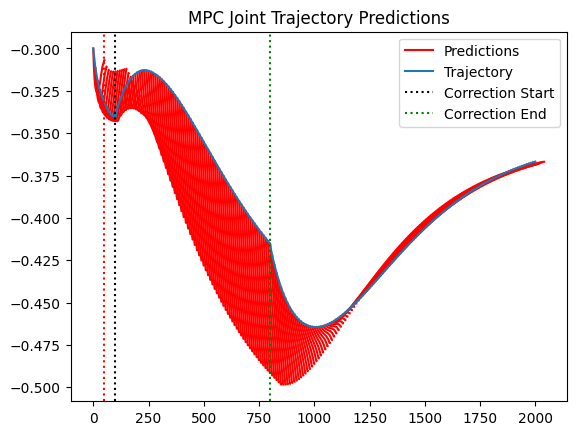

In [52]:
s_id = 4 # which state value to plot: [q, q_dot] from 0 to 13 

for i in range(mpc_cycle):
    if (i%10 == 0):
        t = np.linspace(i,i+T,T+1)
        if i == 0:
            plt.plot(t,sim_data['state_pred'][i,:,s_id],color='red')
        else:
            plt.plot(t,sim_data['state_pred'][i,:,s_id],color='red', label='_nolegend_')
plt.plot(sim_data['state_mea_SIM_RATE'][:,s_id])
if apply_correction:
    plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
    plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
    plt.legend(['Predictions', 'Trajectory','Correction Start','Correction End'])
else:
    plt.legend(['Predictions', 'Trajectory'])
plt.title('MPC Joint Trajectory Predictions')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

diff_pred = []
for i in range(mpc_cycle-1):
    state_prev = sim_data['state_pred'][i,1:,s_id]
    state_curr = sim_data['state_pred'][i+1,:-1,s_id]
    diff_pred.append(np.linalg.norm(state_prev-state_curr))

# diff_pred = np.stack(diff_pred)
# plt.plot(diff_pred)
# if apply_correction:
#     plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
#     plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
#     plt.legend(['Consecutive Error','Correction Start','Correction End'])
# else:
#     plt.legend(['Consecutive Error'])
# plt.title('MPC Joint Trajectory Consecutive Error')
# plt.show()

# costs = np.stack(cost_hist)
# plt.plot(costs)
# if apply_correction:
#     plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
#     plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
#     plt.legend(['Cost','Correction Start','Correction End'])
# else:
#     plt.legend(['Cost'])
# plt.title('Cost History')
# plt.show()

In [ ]:
sim_data['pose_pred'] = convert_2_cart(sim_data['state_pred'], endeff_frame_id)

In [ ]:
xyz = 2 # 0 for X, 1 for Y, and 2 for Z axes

pose_hist = np.vstack(pose)
for i in range(mpc_cycle):
    if (i%20 == 0):
        t = np.linspace(i,i+T,T+1)
        if i == 0:
            plt.plot(t,sim_data['pose_pred'][i,:,xyz],color='red')
        else:
            plt.plot(t,sim_data['pose_pred'][i,:,xyz],color='red',label='_nolegend_')
plt.plot(pose_hist[:,xyz])
if apply_correction:
    plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
    plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
    plt.legend(['Predictions', 'Trajectory','Correction Start','Correction End'])
else:
    plt.legend(['Predictions', 'Trajectory'])
plt.title('MPC Cartesian Trajectory Predictions')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

# diff_pred_cart = []
# for i in range(mpc_cycle-1):
#     cart_prev = sim_data['pose_pred'][i,1:,xyz]
#     cart_curr = sim_data['pose_pred'][i+1,:-1,xyz]
#     diff_pred_cart.append(np.linalg.norm(cart_prev-cart_curr))
# diff_pred_cart = np.stack(diff_pred_cart)
# plt.plot(diff_pred_cart)
# if apply_correction:
#     plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
#     plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
#     plt.legend(['Consecutive Error','Correction Start','Correction End'])
# else:
#     plt.legend(['Consecutive Error'])
# plt.title('MPC Cartesian Trajectory Predictions Consecutive Error')
# plt.show()

In [ ]:
# Plot the X, Y, and Z trajectories of the end-effector
plt.plot(pose_hist)
plt.legend(['x', 'y', 'z'])
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.title('X, Y, and Z Trajectories of the End-Effector')
plt.show()

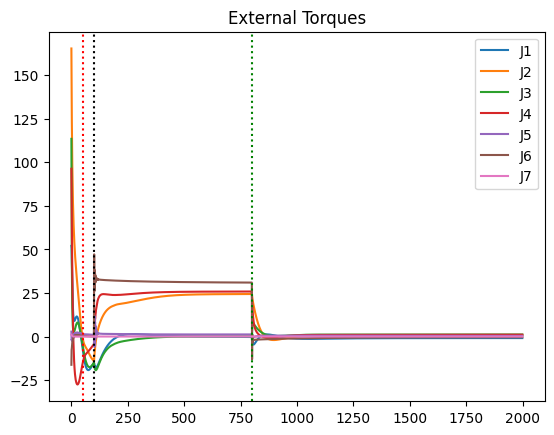

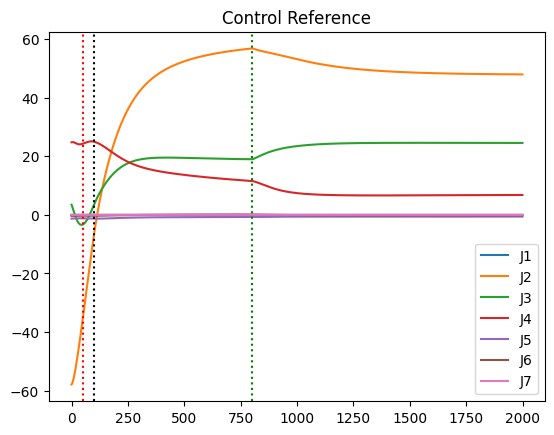

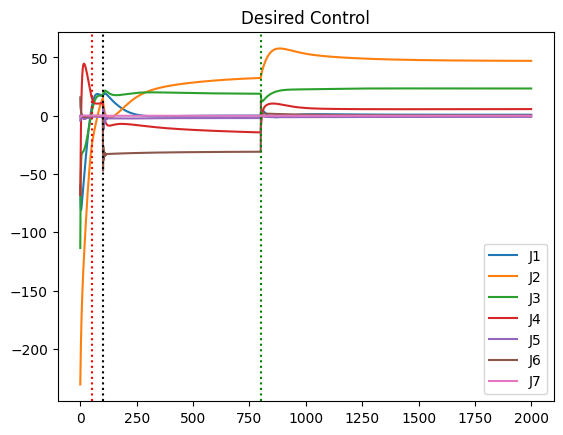

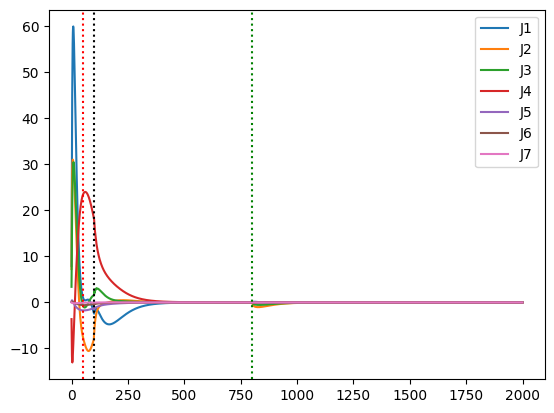

In [53]:
tau_ext = np.stack(tau_ext)
# External Torque Computed as: M*q_ddot + b - tau 
plt.plot(tau_ext)
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.title('External Torques')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

# Control Reference
plt.plot(sim_data['ctrl_ref'])
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.title('Control Reference')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

# Desired Control
plt.plot(sim_data['ctrl_des_SIM_RATE'])
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.title('Desired Control')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

plt.plot(sim_data['ctrl_ref'] - sim_data['ctrl_des_SIM_RATE'] - tau_ext)
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

In [ ]:
plt.plot(np.diff(tau_ext))
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.title('External Torques Difference')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

In [ ]:
tau_sqr = tau_ext**2
# tau_sqr = tau_sqr/(np.max(tau_sqr[:sim_data['N_h']]))
plt.plot(tau_sqr[sim_data['N_h']:])
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

tau_norm = np.linalg.norm(tau_sqr,axis=1)
print(np.max(tau_norm[:sim_data['N_h']]))
tau_norm = tau_norm/(np.max(tau_norm[:sim_data['N_h']]))
plt.plot(tau_norm[sim_data['N_h']:])
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

plt.plot(pert)

In [ ]:
if Mujoco_view:
    pert = np.stack(pert)
# div = np.stack(div)
# div_q = np.stack(div_q)
# div_v = np.stack(div_v)